### NEW FEATURE:
#### Individual plots can be achieved by groupby+apply function without looping through dataset.
#### Limit to part of summary table-->merge this summary table with raw df--> apply groupby_plot function to the merged set.


In [18]:
import pandas as pd
import numpy as np

In [19]:
import datetime
from scipy import stats

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

In [22]:
df=pd.read_csv("import-release.csv",index_col=False)

In [128]:
#can be customized based on different grouping schema
grouping_list=['product_name', 'edmq_specification', 'edmq_method','par_name']

In [23]:
df.columns

Index(['product_name', 'edmq_specification', 'edmq_method', 'mfg_site_bldg',
       'par_name', 'batch_number', 'manufacture_date', 'lsl', 'usl', 'lcl',
       'ucl', 'aml_text', 'aml_value', 'adl_text', 'adl_value'],
      dtype='object')

In [24]:
df.shape

(8875, 15)

In [122]:
df["batch_number"]=df["batch_number"].astype(str)

### -------------------------------------Generate Summary Table-------------------------------------

In [58]:
#should further upgrade this to allow for specification on columns
def ttest_group(df,equal_variance_indicator=True):
    return(stats.ttest_ind(df["aml_value"],df["adl_value"],equal_var =equal_variance_indicator)[1])

In [81]:
#return upper p value, input <1 ratio, this p value should compare to 0.025, two sided test
def ftest_group(df):
    sd1=np.std(df["aml_value"],ddof=1)
    sd2=np.std(df["adl_value"],ddof=1)
    if (sd1==0 or sd2==0):
        return(np.nan)
    else:
        sd_ratio=sd1/sd2 if sd1>sd2 else sd2/sd1
        return(1-stats.f.cdf(sd_ratio, len(df["aml_value"])-1,len(df["aml_value"])-1))

In [90]:
def adtest_group(df):
    if( (len(pd.unique(df["aml_value"]))<2) or (len(pd.unique(df["aml_value"]))<2)):
        return(np.nan)
    else:
        return(stats.anderson_ksamp(samples=[df["aml_value"],df["adl_value"]])[2])

In [100]:
def kstest_group(df):
    if len(df)<4:
        return (np.nan)
    else:
    
        return(stats.ks_2samp(df["aml_value"], df["adl_value"])[1])

In [129]:
summary_df=pd.DataFrame(data={\
        "N":df.groupby(grouping_list)['aml_value'].count(),\
        "AML_mean":df.groupby(grouping_list)['aml_value'].mean(),\
        "ADL_mean":df.groupby(grouping_list)['adl_value'].mean(),\
        "pvalue(ttest)":df.groupby(grouping_list).apply(ttest_group,equal_variance_indicator=True),\
        "pvalue(adtest)":df.groupby(grouping_list).apply(adtest_group),\
        "AML_std":df.groupby(grouping_list)['aml_value'].std(),\
        "ADL_std":df.groupby(grouping_list)['adl_value'].std(),\
        "pvalue(Ftest)":df.groupby(grouping_list).apply(ftest_group),\
        "pvalue(KStest)":df.groupby(grouping_list).apply(kstest_group)
        })

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [130]:
summary_df.reset_index(inplace=True)

In [133]:
summary_df["Relative_Difference%(ADL-AML)"]=(summary_df["ADL_mean"]-summary_df["AML_mean"])/summary_df["AML_mean"]*100

In [141]:
summary_df.to_csv("import-release-summarystats.csv",index=False)

### ------------------------------------------------------- Apply Criteria-------------------------------------------------

In [135]:
lowks=summary_df[(summary_df["pvalue(KStest)"]<0.01)&(summary_df["N"]>=15)]


In [145]:
def subplot_group(df):
    plt.figure(figsize=(10,7))
    plt.plot(df['manufacture_date']+" | "+df["batch_number"],df["aml_value"],"o",label="AML")
    plt.plot(df['manufacture_date']+" | "+df["batch_number"],df["adl_value"],"o",label="ADL")
    plt.title(df["product_name"].iloc[0]+"-"+df["edmq_specification"].iloc[0]+"\n"+df['edmq_method'].iloc[0]\
              +"-"+df["par_name"].iloc[0])
    plt.xticks(rotation=90)
    plt.legend()
    plt.savefig(pp, format='pdf',bbox_inches="tight");

In [146]:
df_summary_lowks_merged=pd.merge(df,lowks,on=grouping_list)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


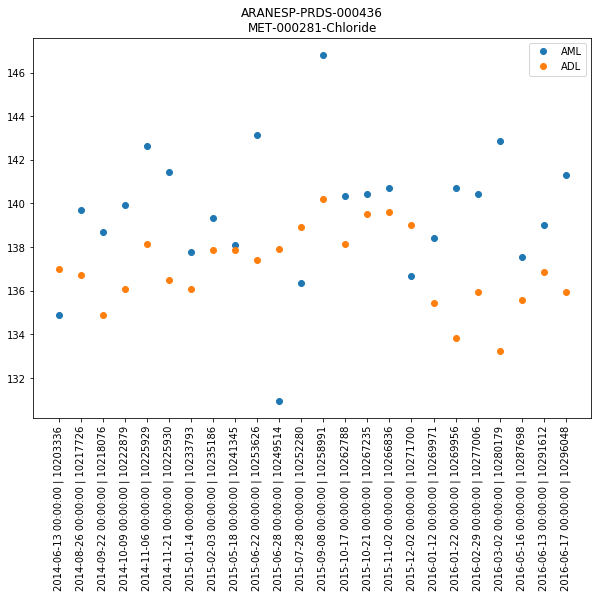

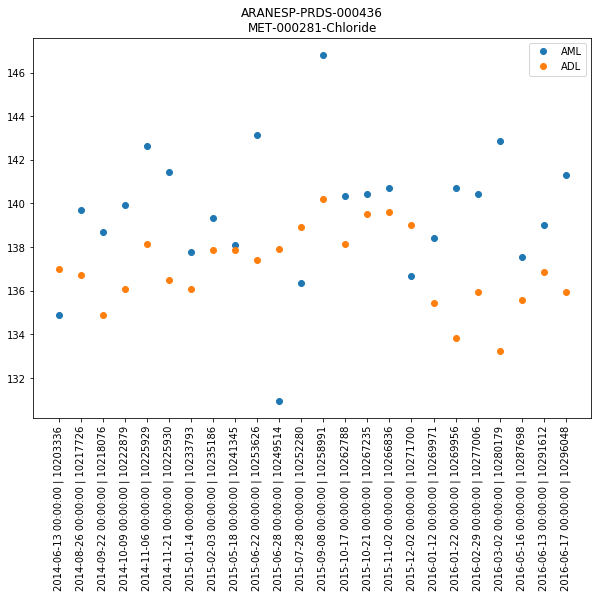

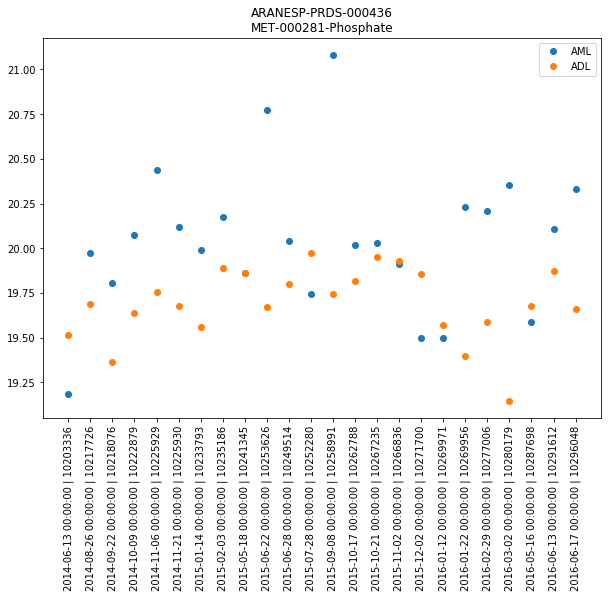

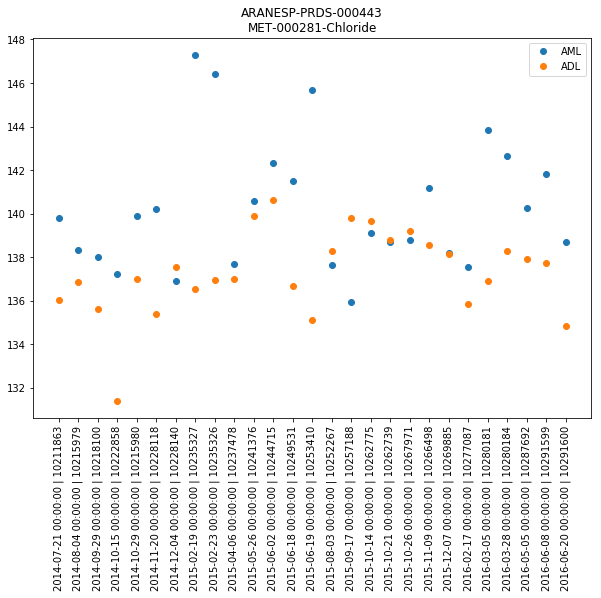

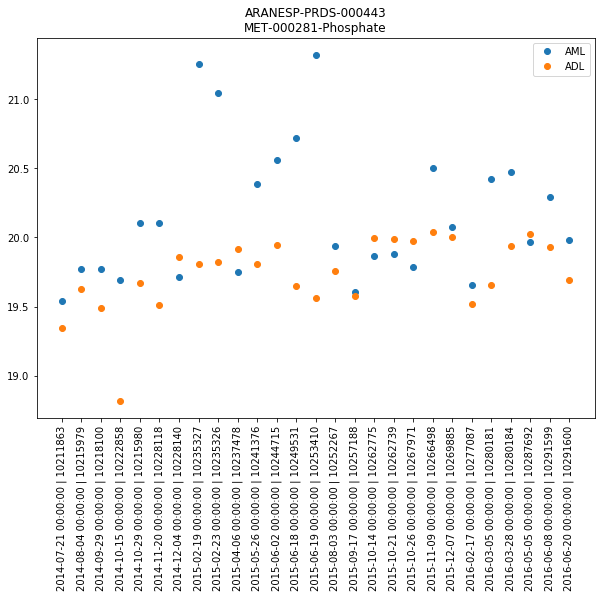

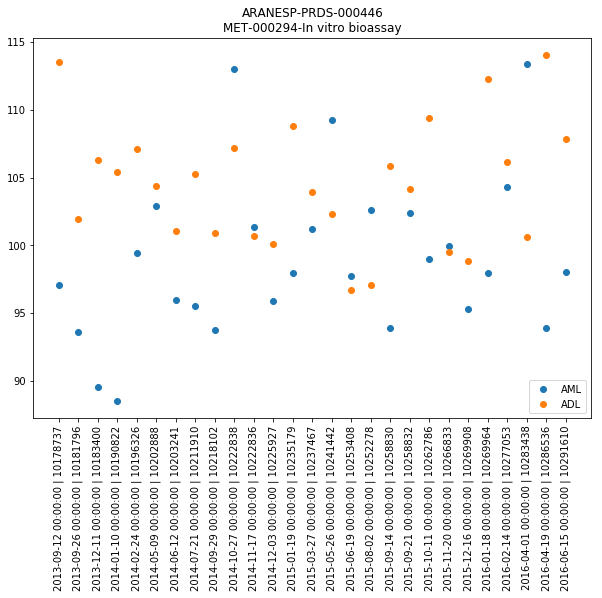

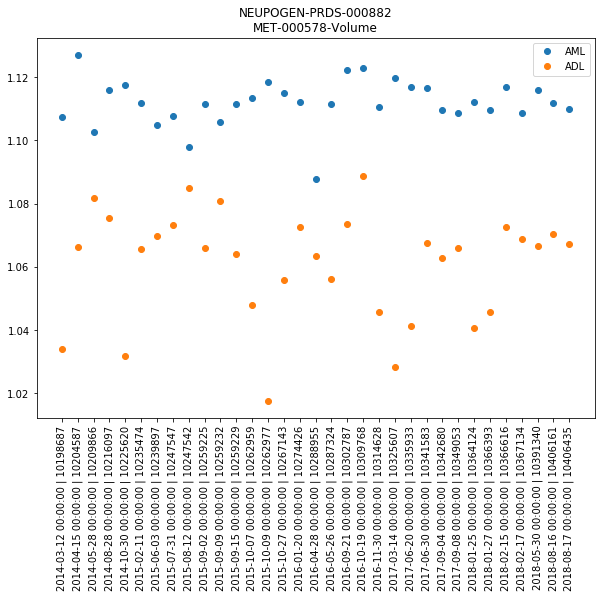

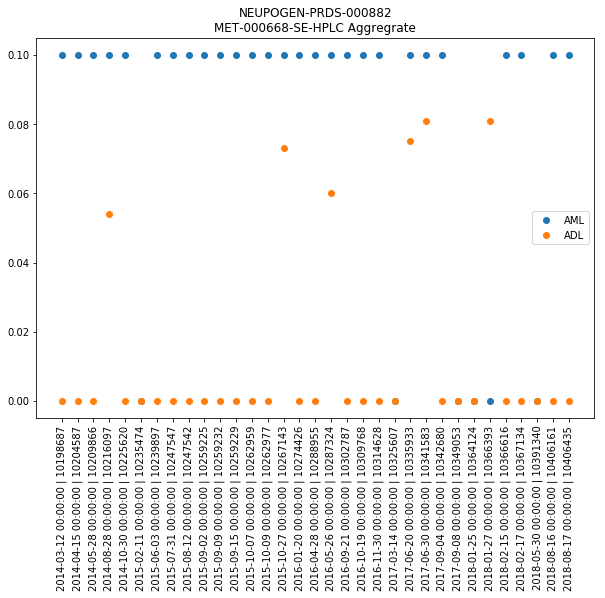

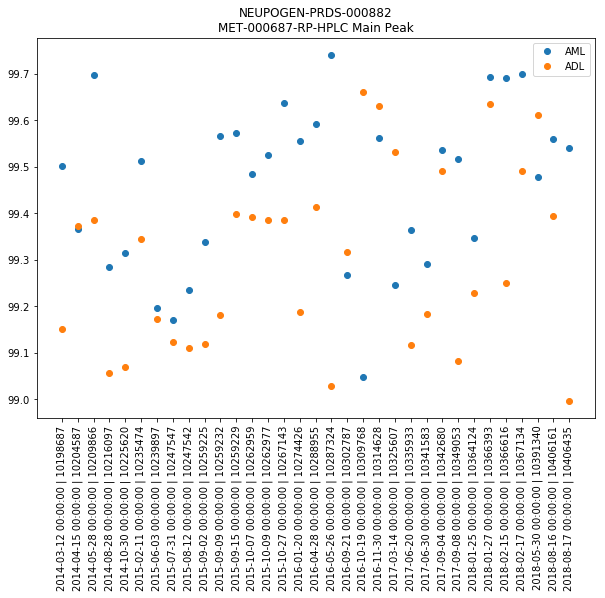

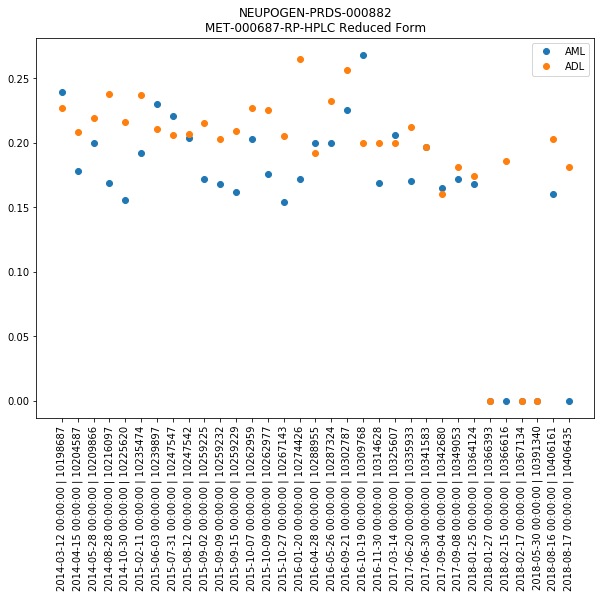

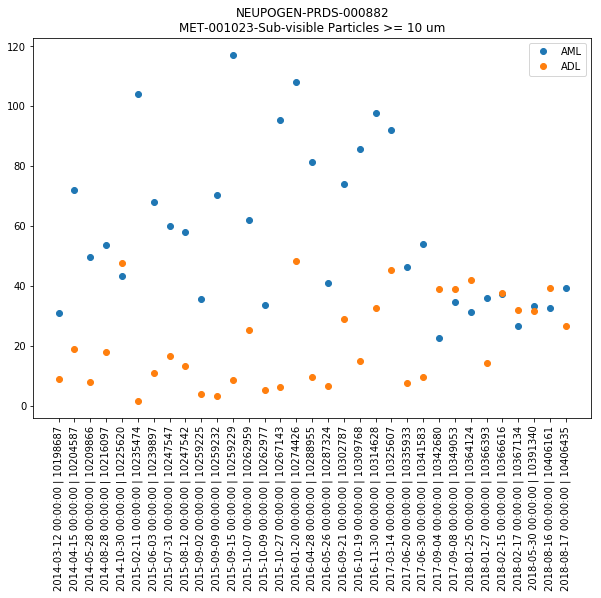

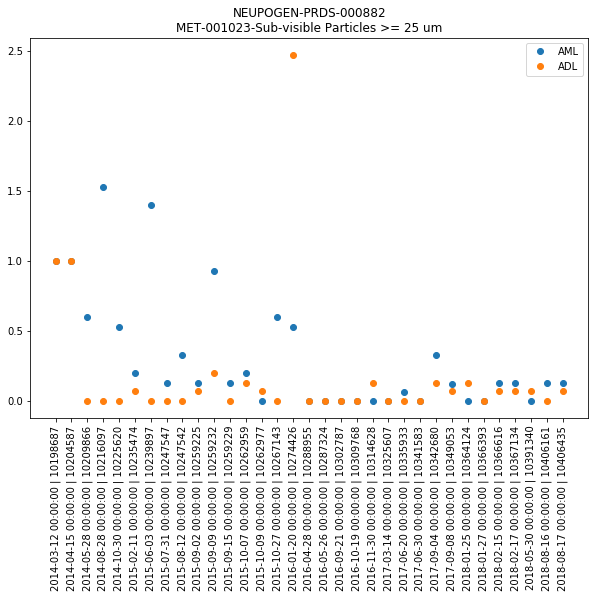

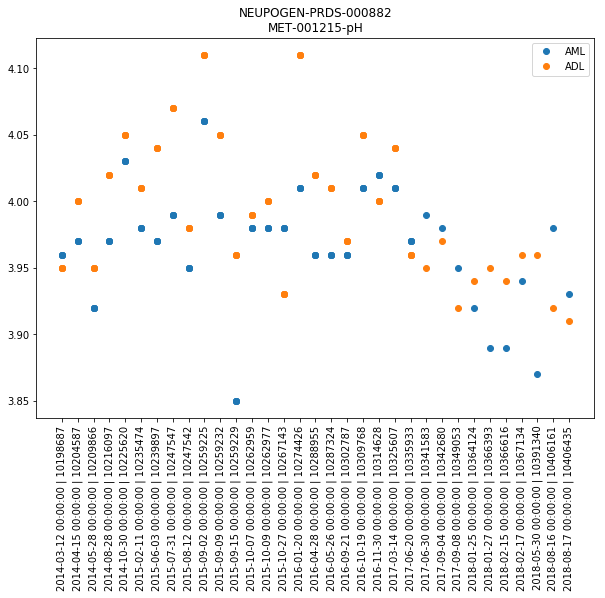

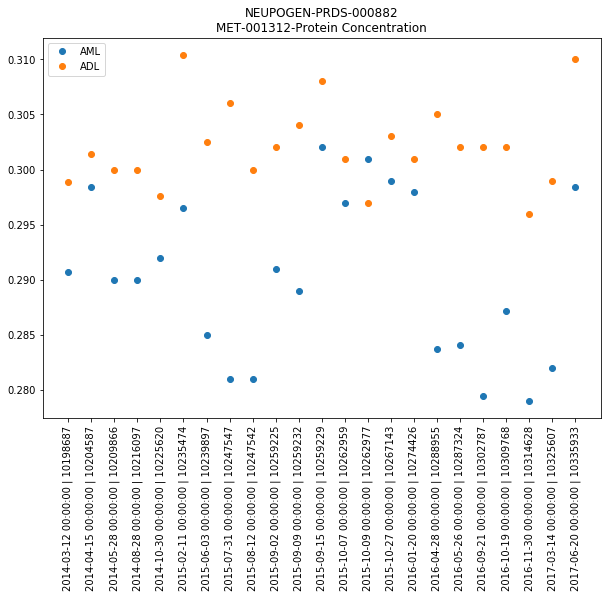

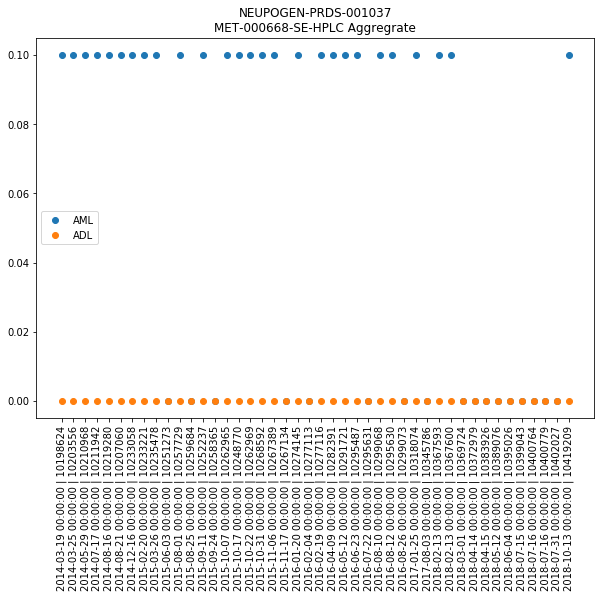

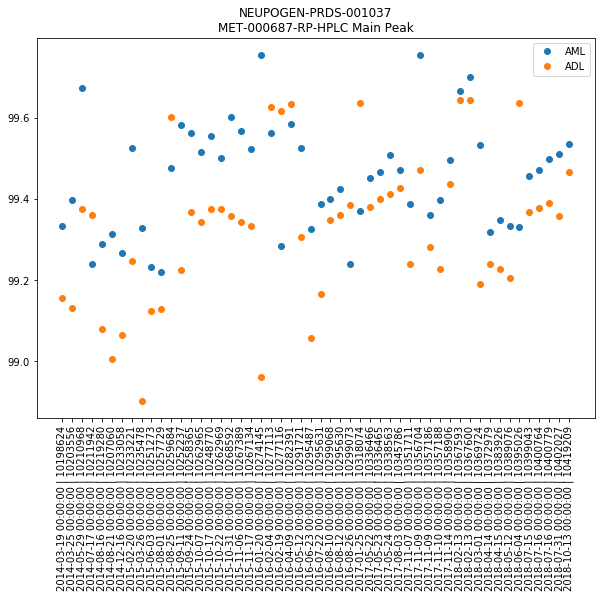

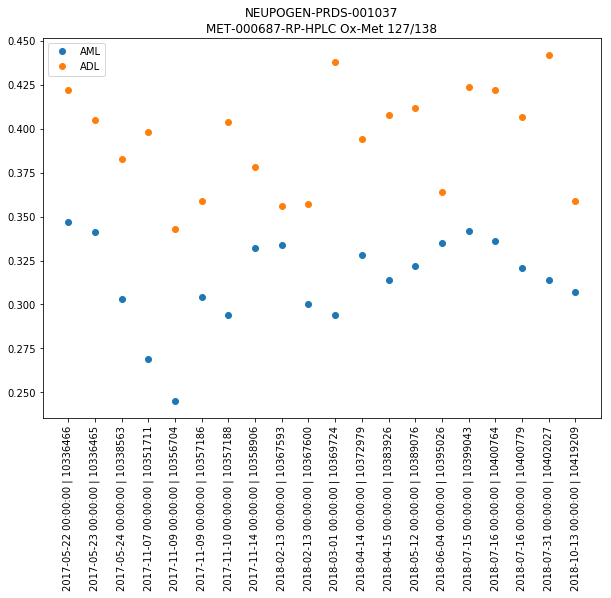

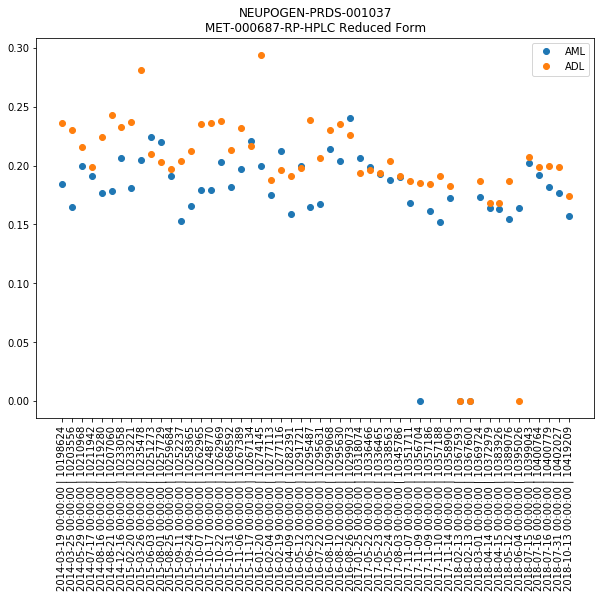

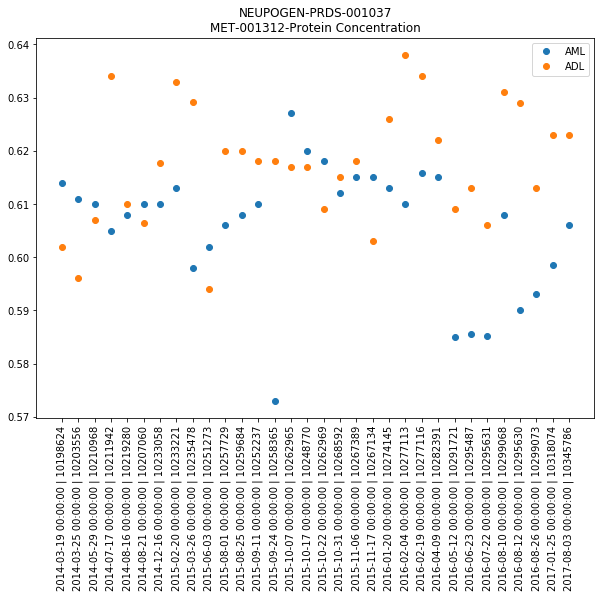

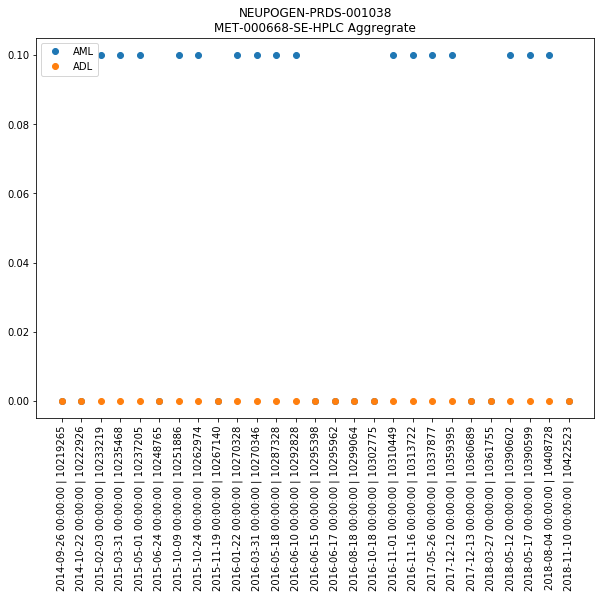

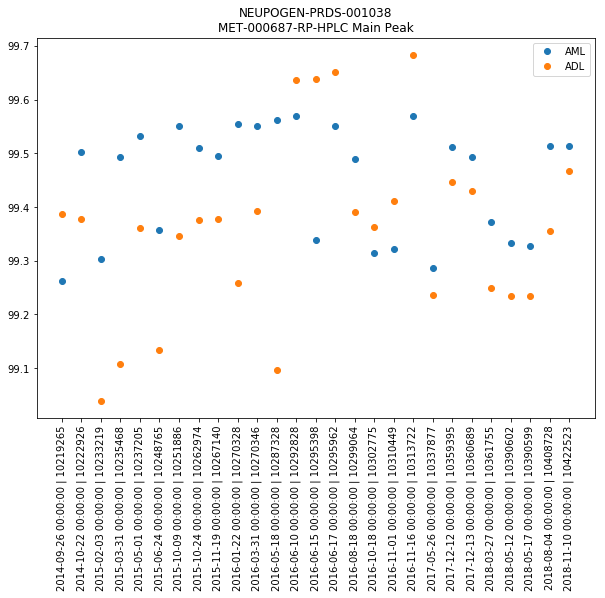

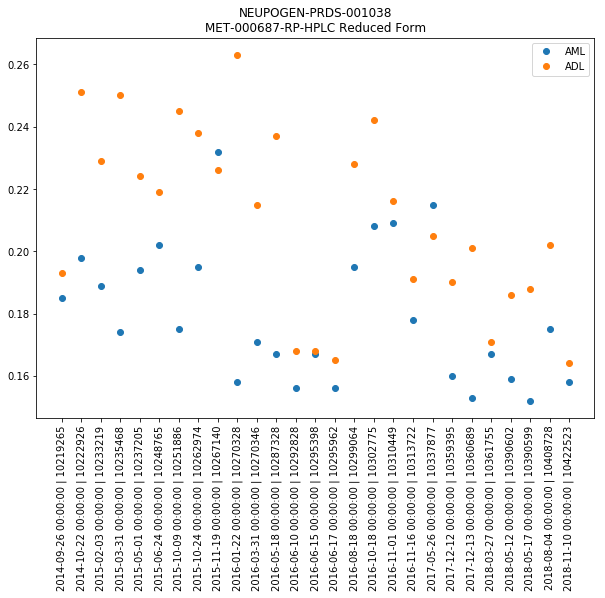

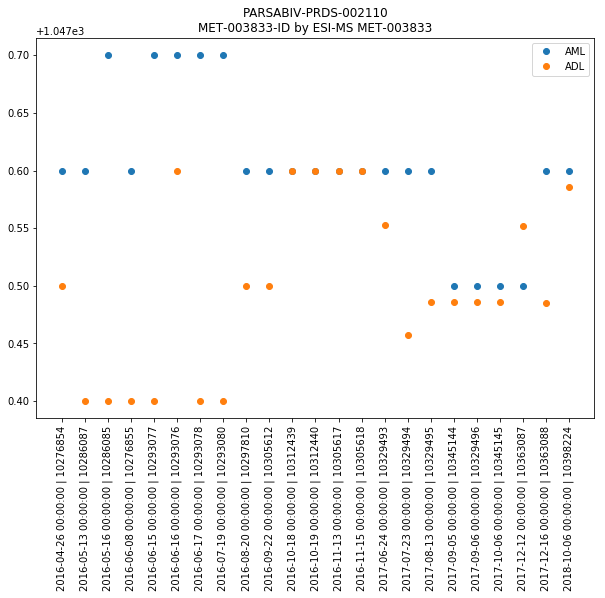

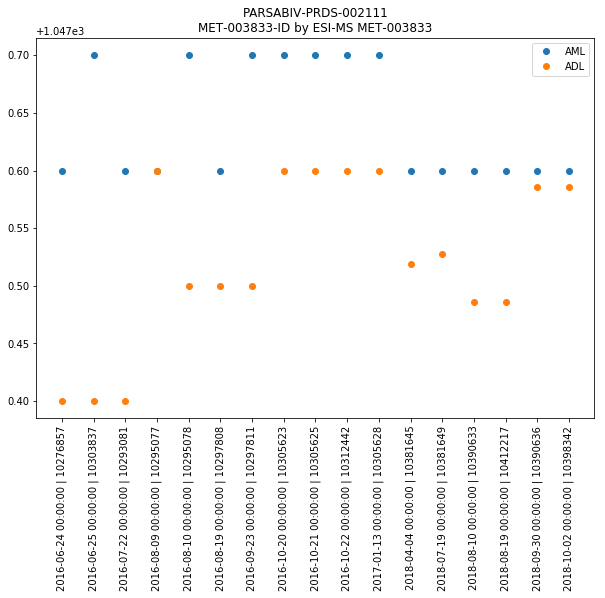

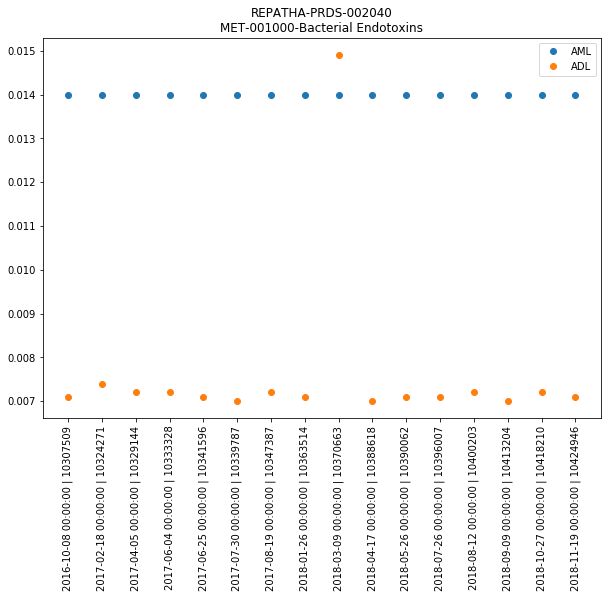

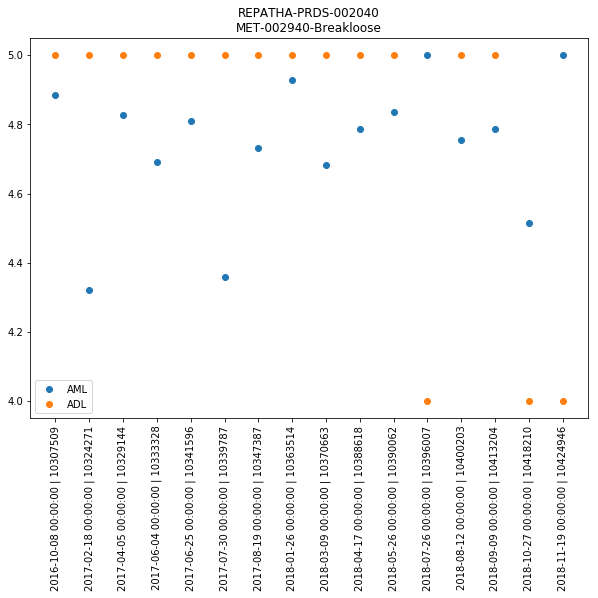

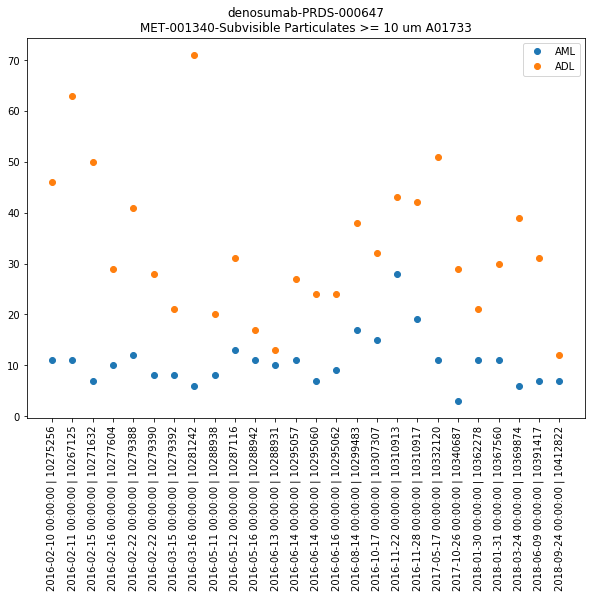

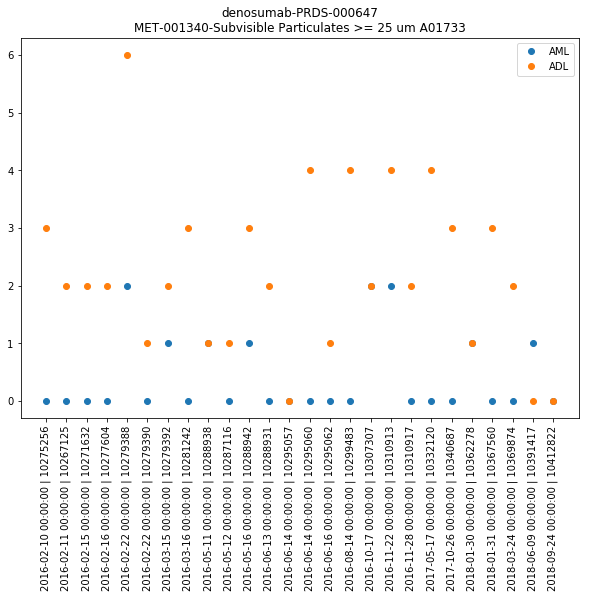

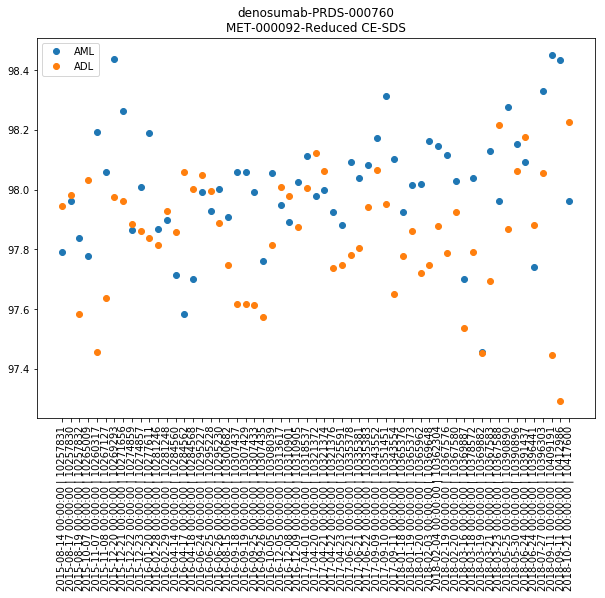

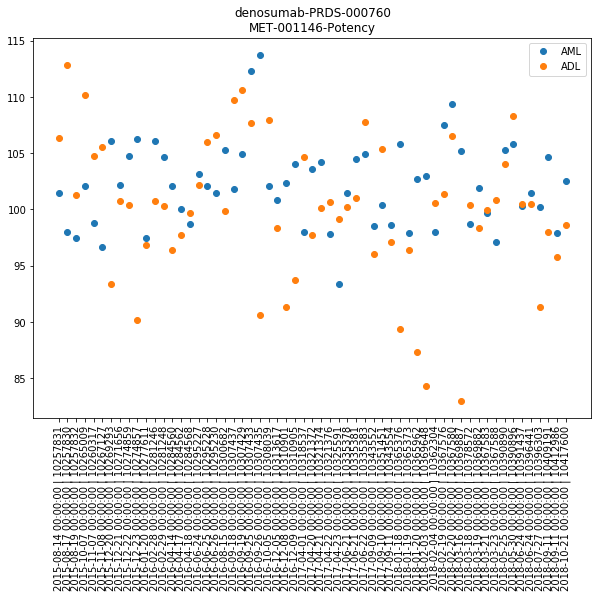

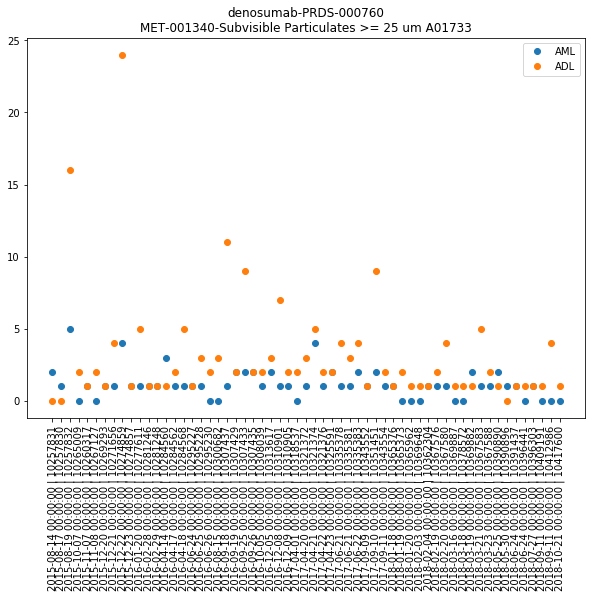

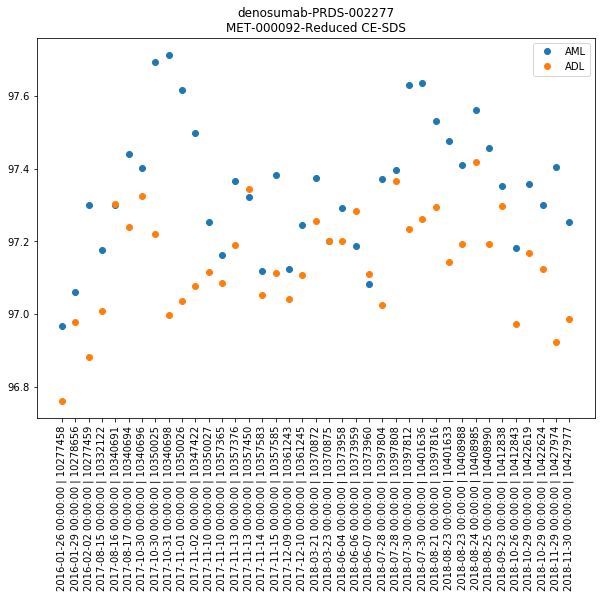

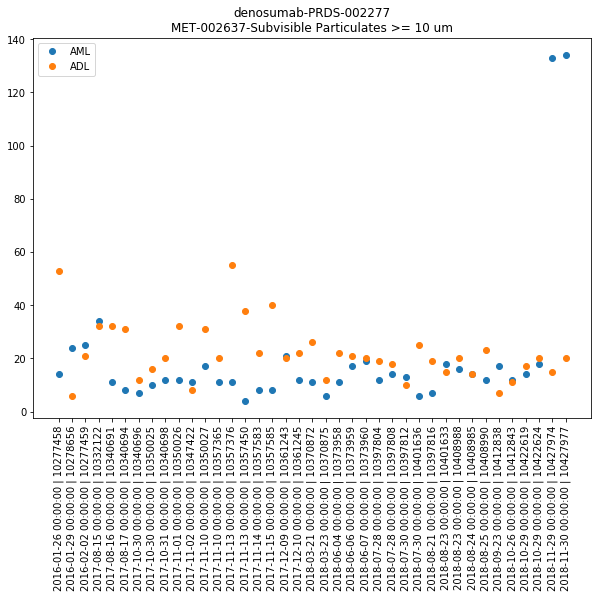

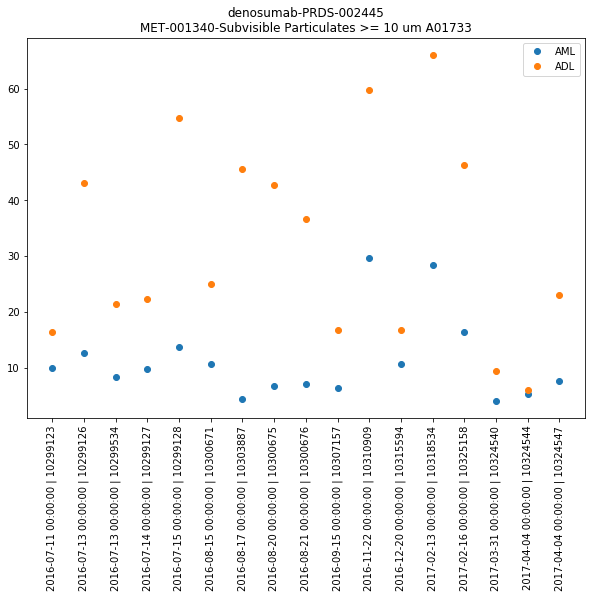

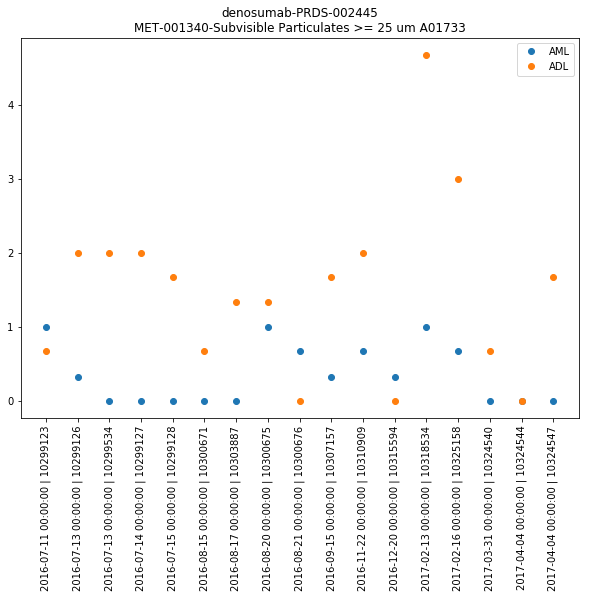

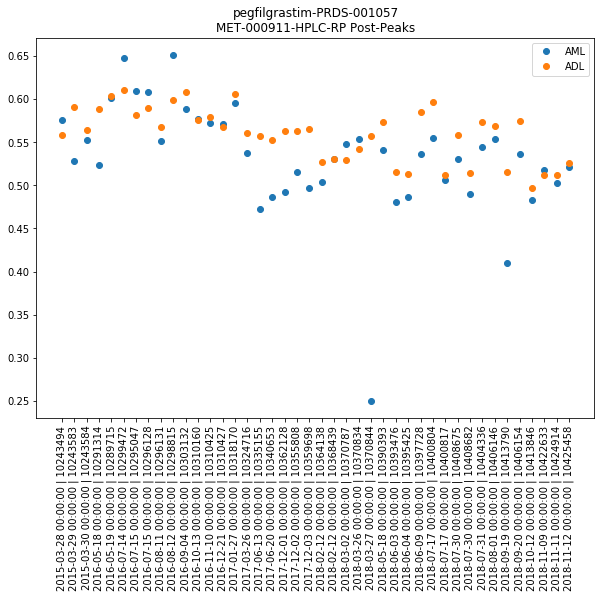

In [147]:
pp = PdfPages('lowKS_plotgrouping.pdf')
df_summary_lowks_merged.groupby(grouping_list).apply(subplot_group)
pp.close()

In [105]:
summary_df[(summary_df["pvalue(Ftest)"]<0.05)&(summary_df["N"]>=15)]

,product_name,edmq_specification,edmq_method,mfg_site_bldg,par_name,ADL_mean,ADL_std,AML_mean,AML_std,N,pvalue(Ftest),pvalue(KStest),pvalue(adtest),pvalue(ttest)
23,ARANESP,PRDS-000436,MET-000281,PRJU:APR1,Phosphate,19.655389,0.191322,20.081889,0.442459,18,4.652413e-02,2.846570e-04,0.000426,6.519505e-04
120,ARANESP,PRDS-000444,MET-001000,PRJU:APR1,Bacterial Endotoxins,0.040833,0.004506,0.040000,0.000000,120,1.110223e-16,9.999998e-01,NaN,4.391182e-02
128,ARANESP,PRDS-000444,MET-001132,PRJU:APR1,SE-HPLC,99.972567,0.007973,99.972400,0.019742,30,8.627343e-03,7.600465e-01,0.387974,9.659486e-01
142,ARANESP,PRDS-000446,MET-001000,PRJU:APR1,Bacterial Endotoxins,0.050625,0.002500,0.050000,0.000000,16,1.110223e-16,1.000000e+00,NaN,3.253086e-01
186,ARANESP,PRDS-000452,MET-001000,PRJU:APR1,Bacterial Endotoxins,0.040500,0.002236,0.040000,0.000000,20,1.110223e-16,1.000000e+00,NaN,3.236361e-01
230,ARANESP,PRDS-000674,MET-001000,PRJU:APR1,Bacterial Endotoxins,0.060000,0.000000,0.064850,0.016256,48,1.110223e-16,9.945035e-01,0.006931,4.147792e-02
267,NEUPOGEN,PRDS-000882,MET-000578,PRJU:APR1,Volume,1.060196,0.019459,1.111809,0.008617,23,3.116965e-02,2.098318e-10,0.000009,5.175211e-15
326,NEUPOGEN,PRDS-001037,MET-000687,PRJU:APR14,RP-HPLC Altered Form A,0.007750,0.018957,0.060000,0.094032,20,5.091187e-04,2.752689e-01,0.060350,1.965052e-02
328,NEUPOGEN,PRDS-001037,MET-000687,PRJU:APR14,RP-HPLC Ox-Met 122,0.008900,0.021800,0.060000,0.094032,20,1.261759e-03,2.752689e-01,0.060350,2.310296e-02
407,REPATHA,PRDS-002040,MET-001000,PRJU:APR14,Bacterial Endotoxins,0.007619,0.001944,0.014000,0.000000,16,1.110223e-16,3.078379e-07,NaN,5.722818e-14


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


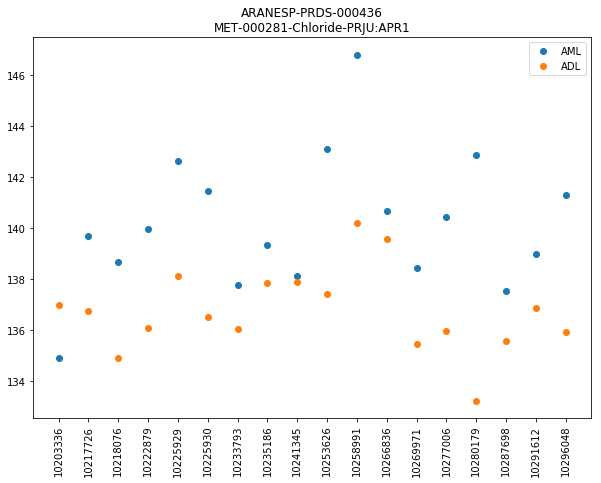

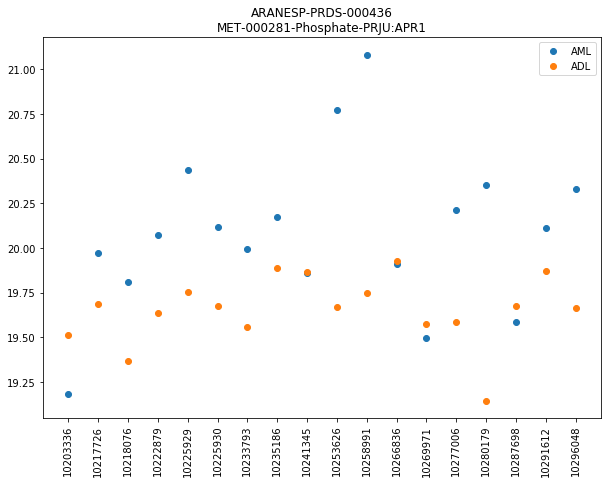

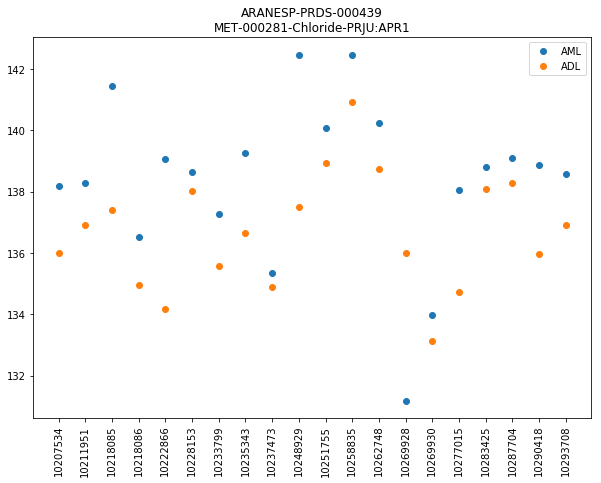

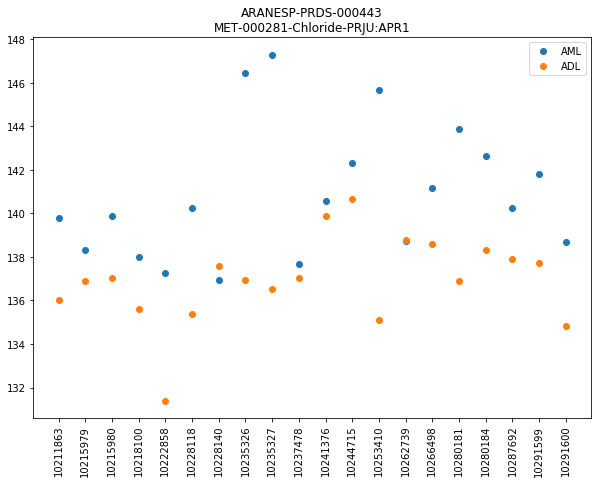

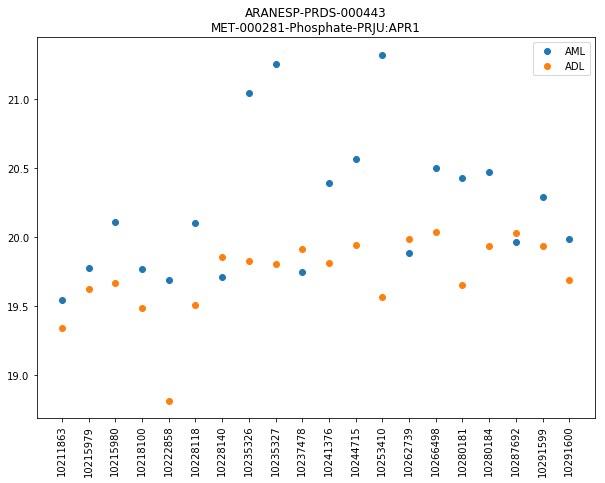

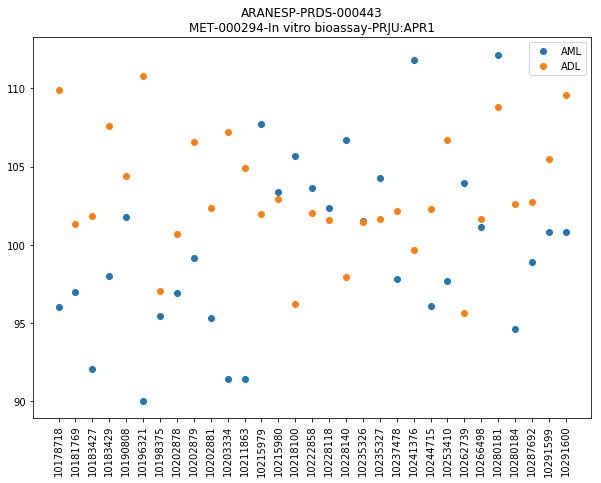

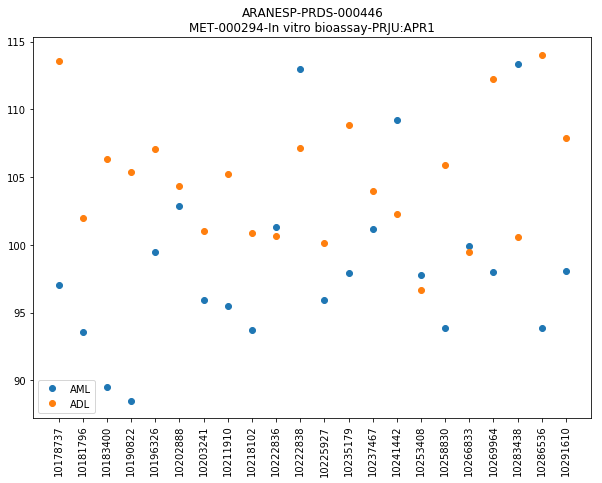

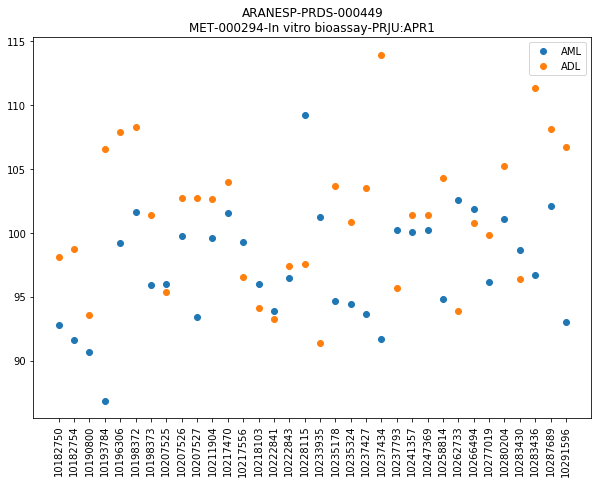

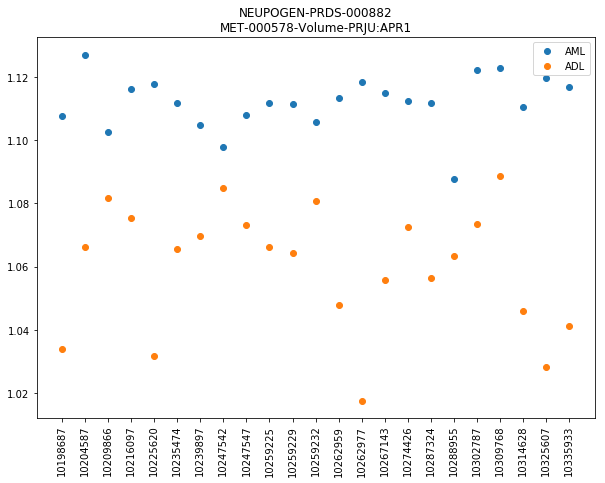

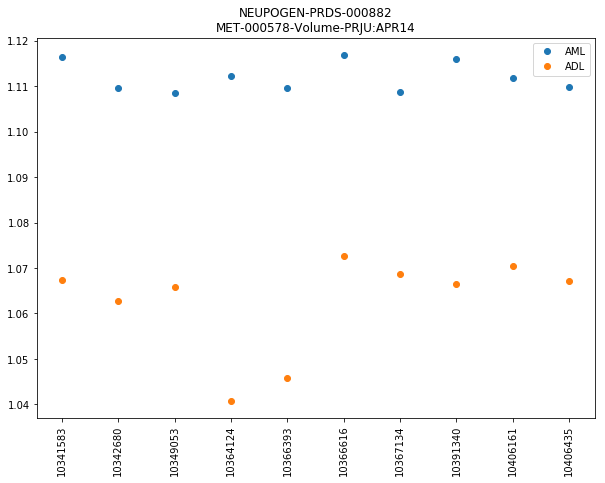

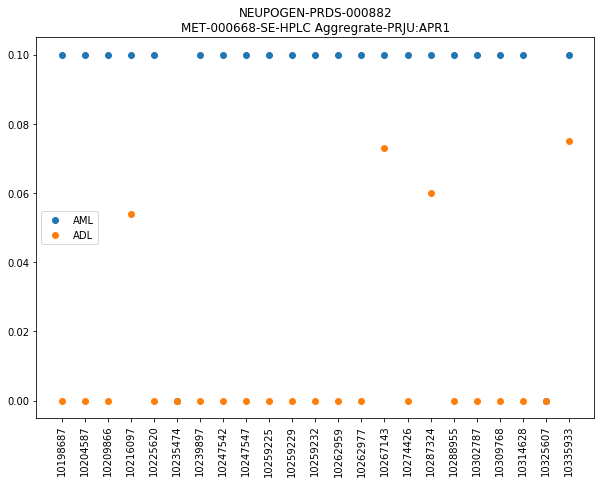

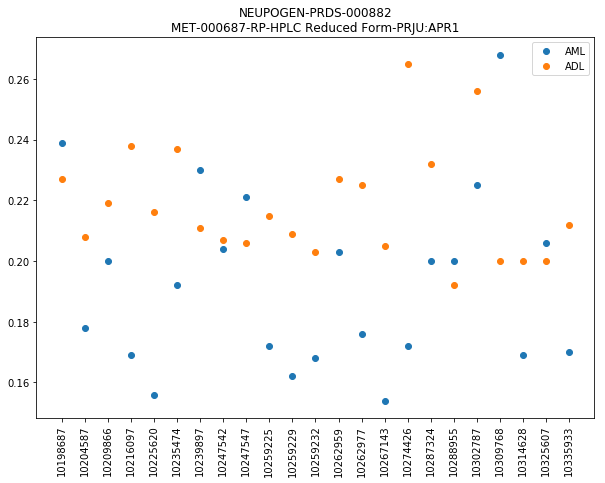

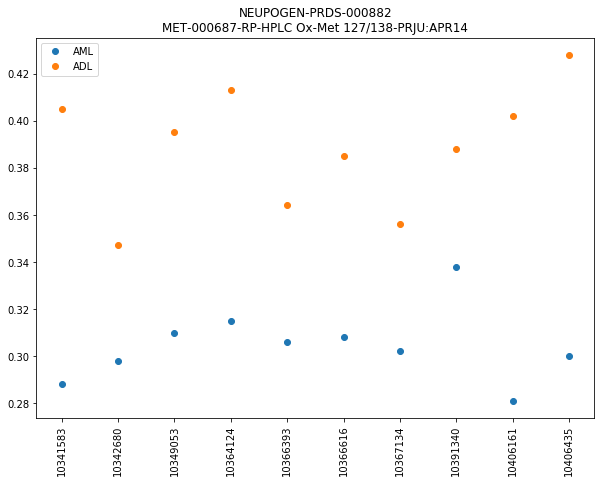

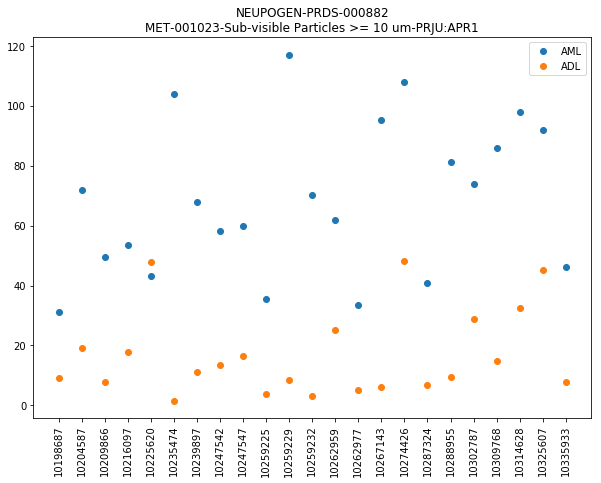

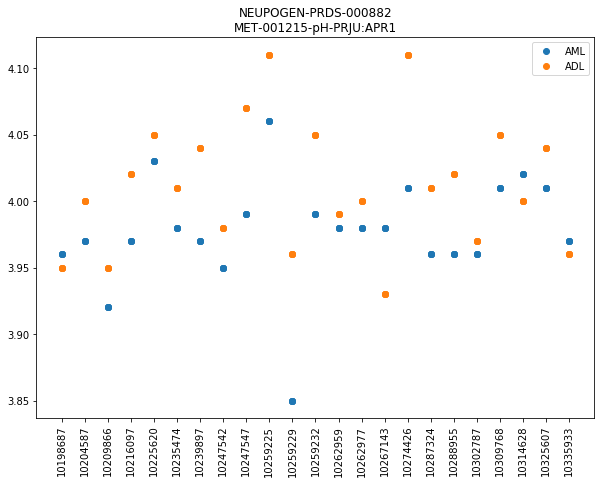

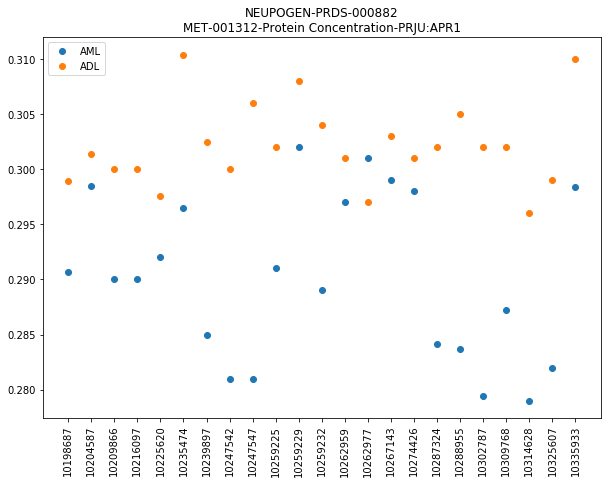

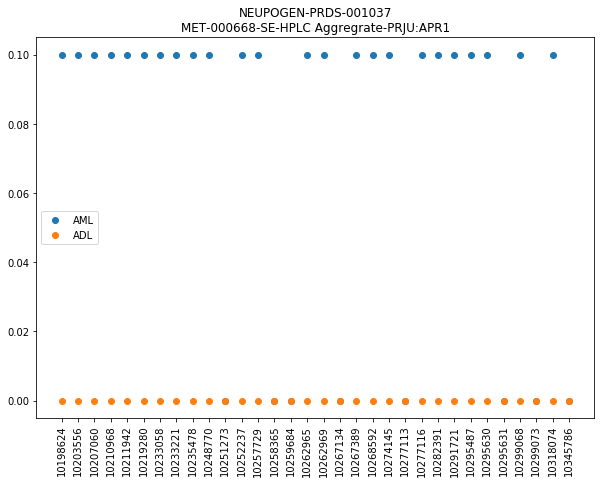

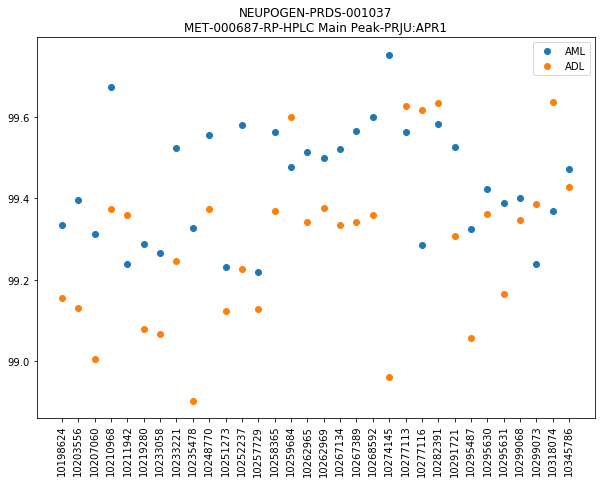

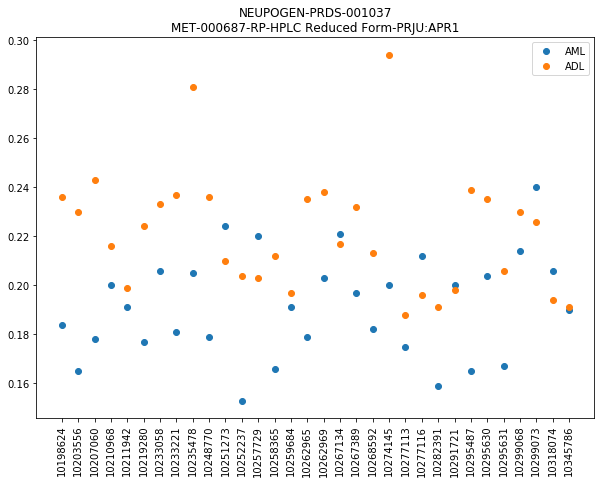

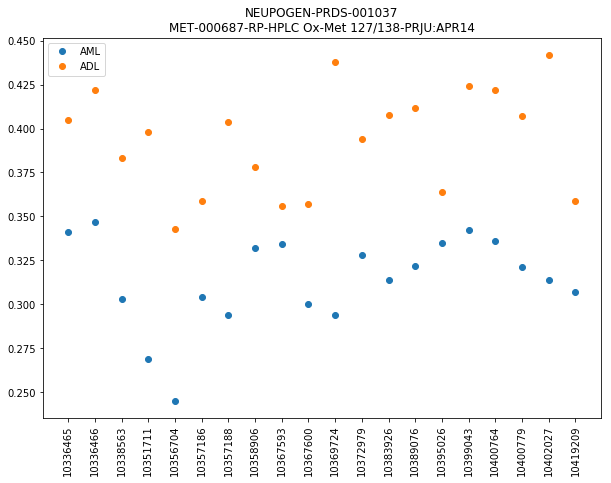

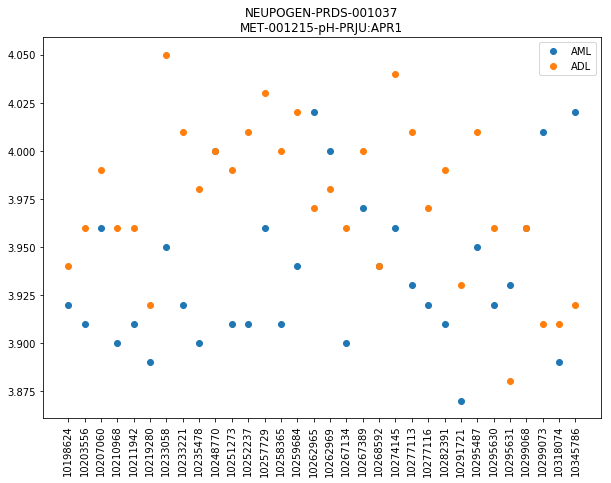

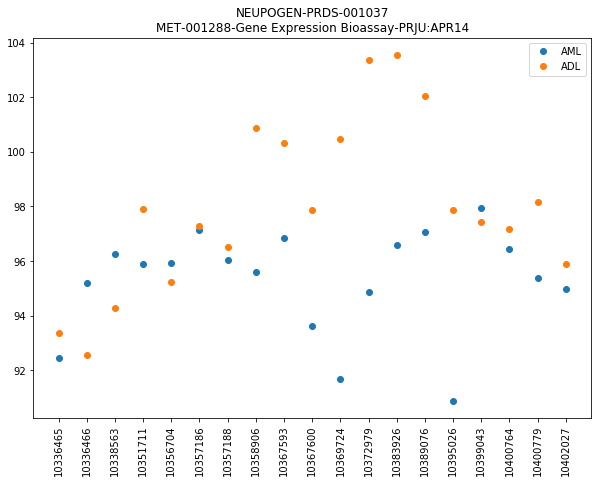

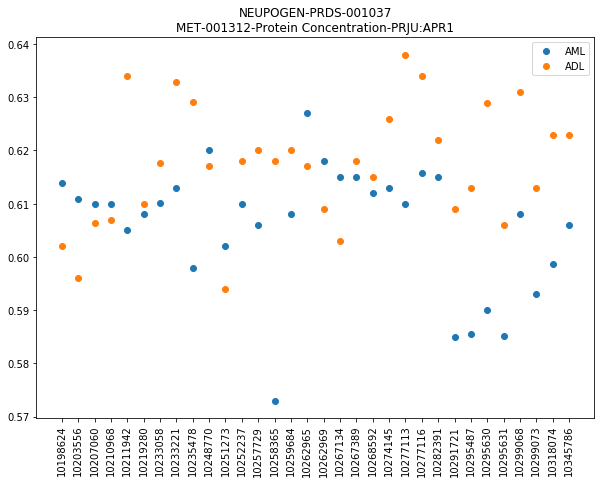

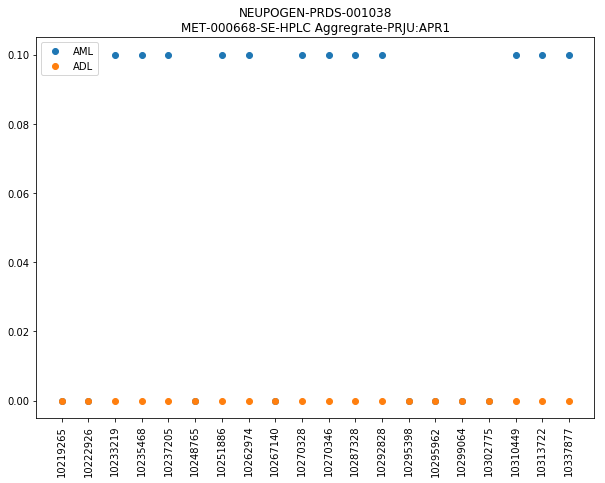

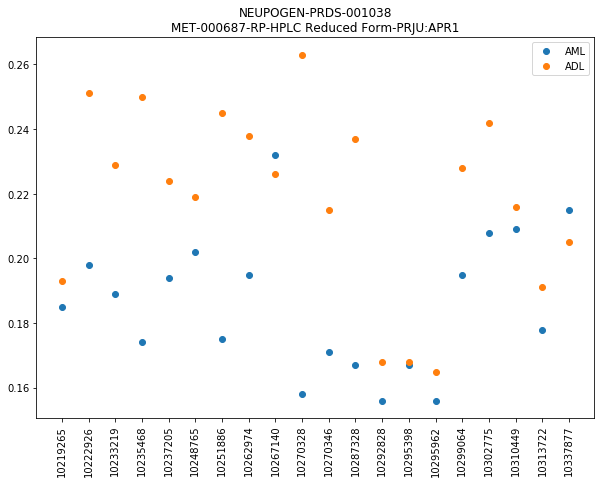

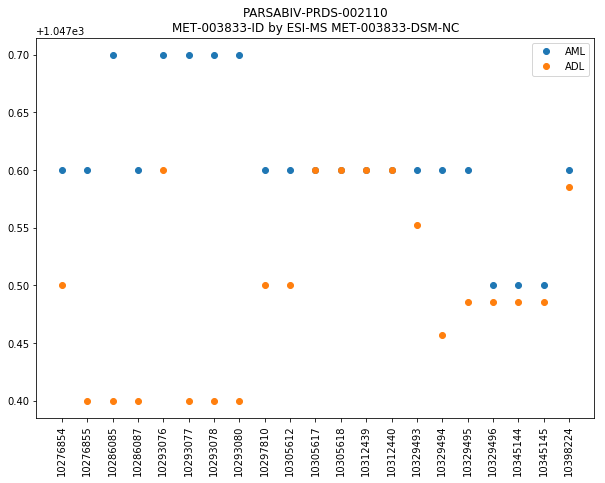

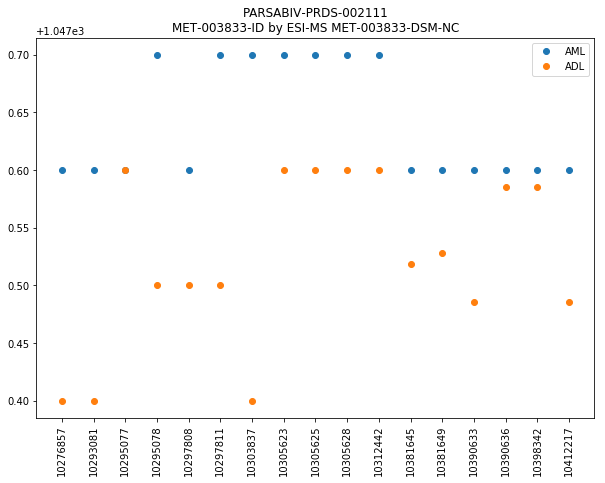

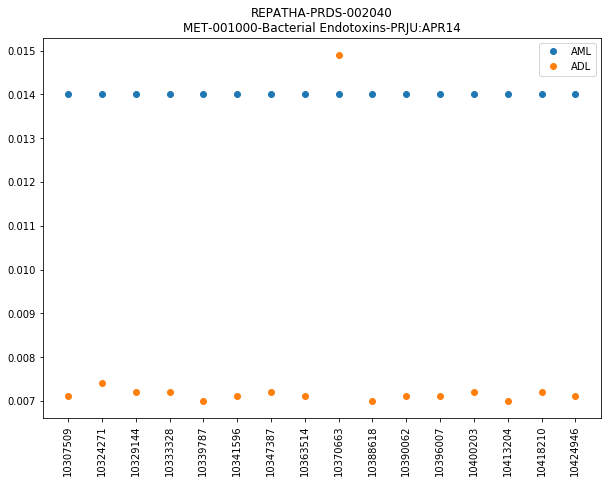

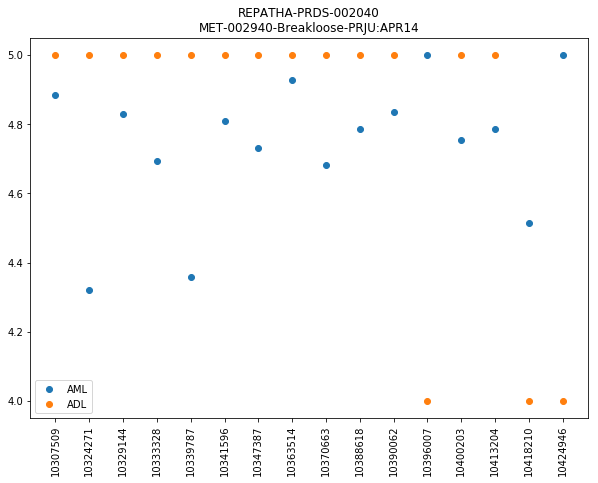

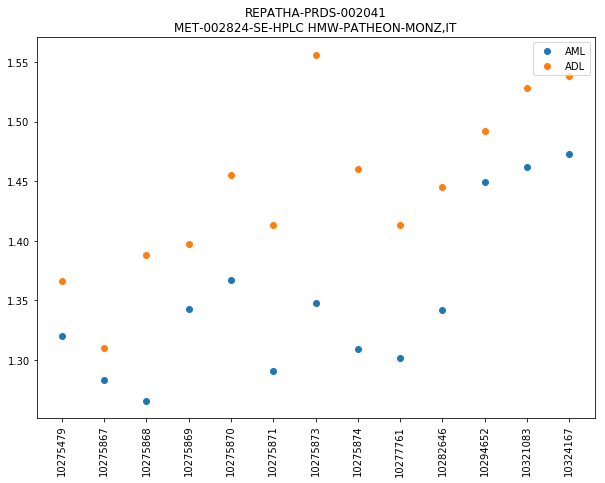

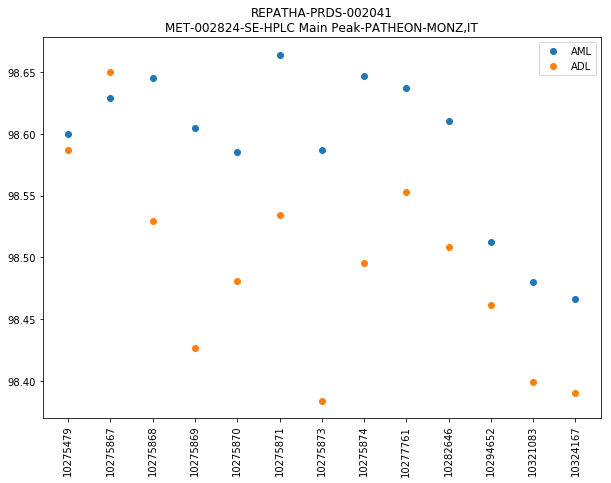

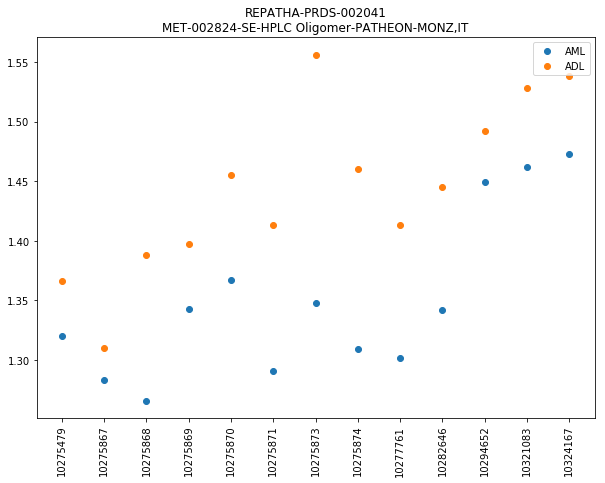

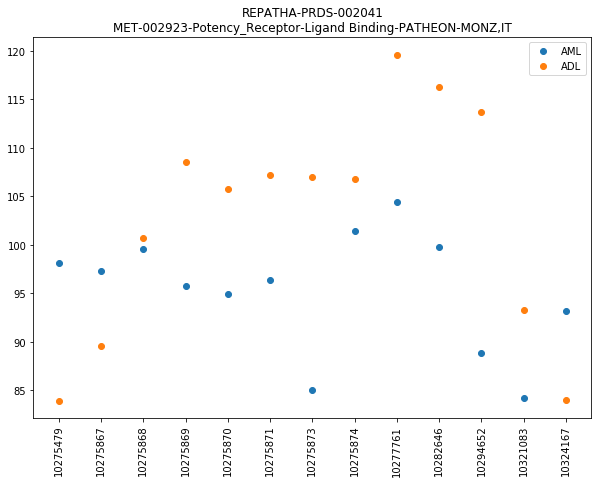

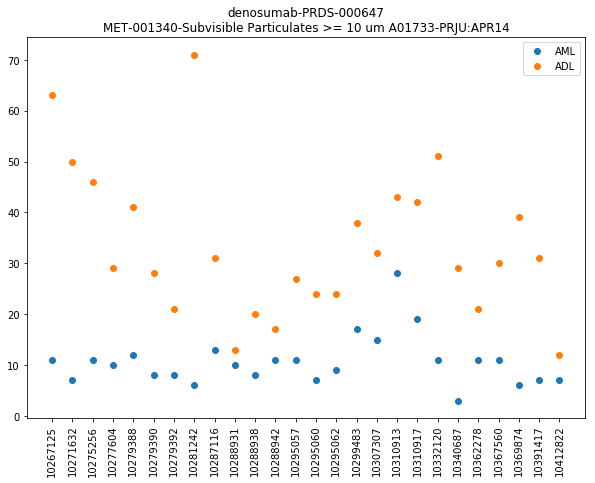

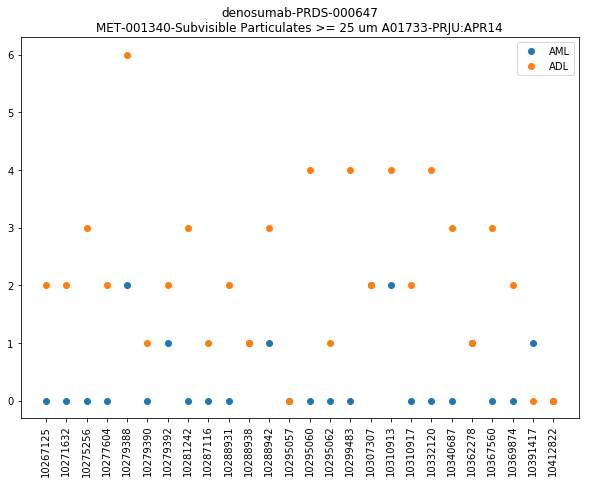

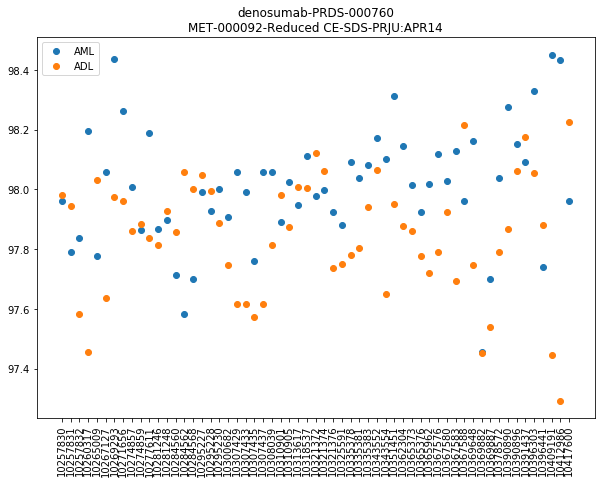

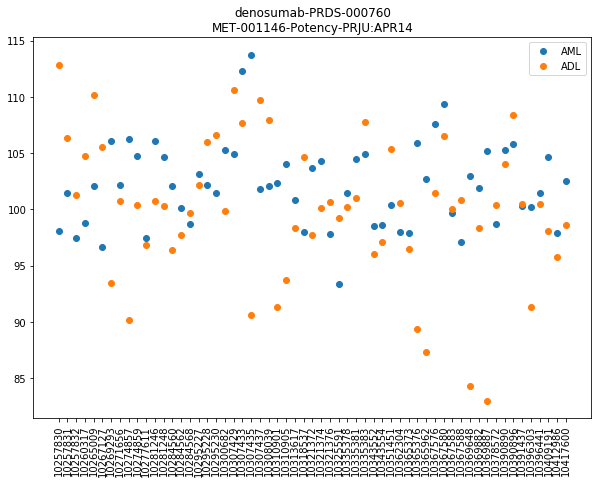

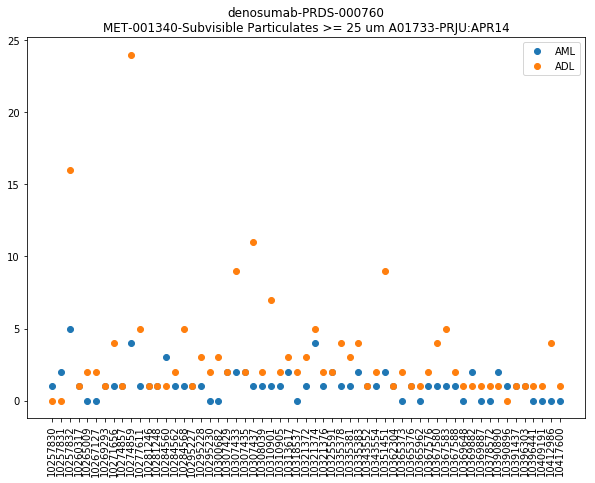

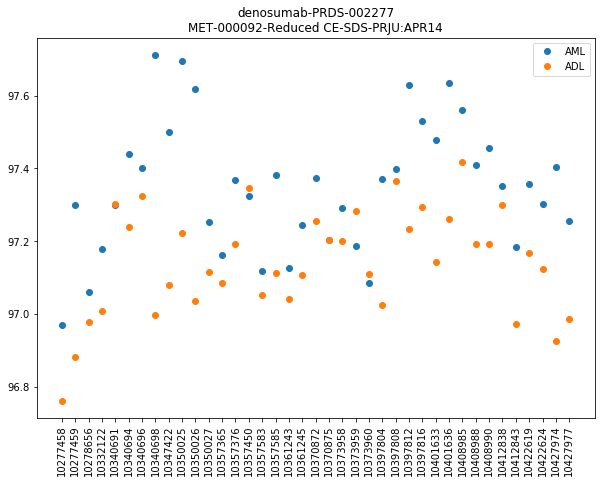

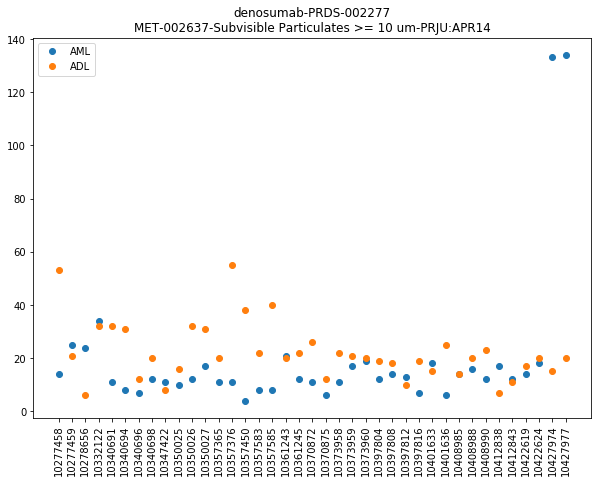

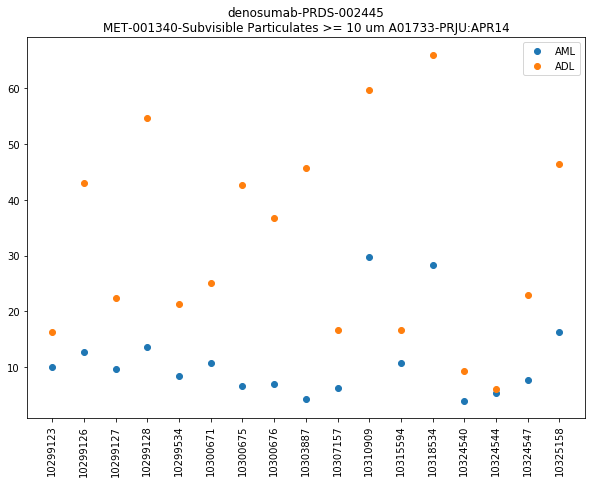

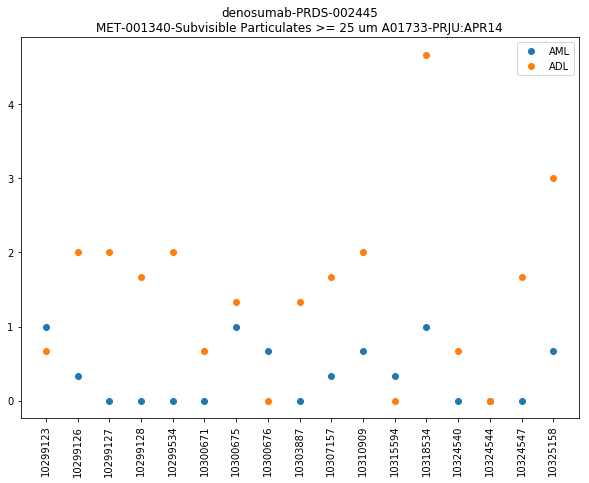

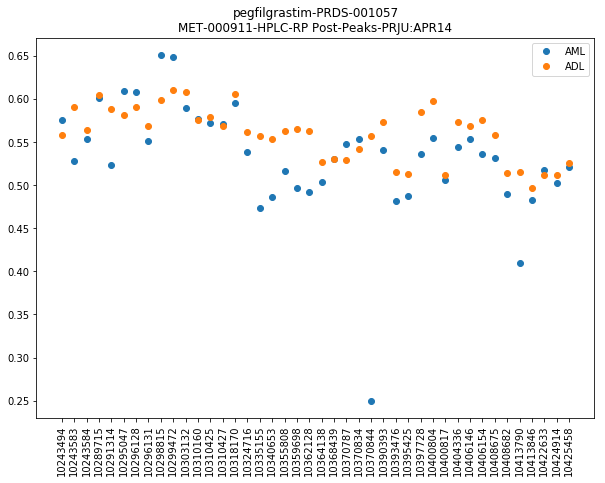

In [123]:
#  Graph drawing using loop. Out of service now.


pp = PdfPages('lowKS.pdf')
for i in range(len(lowks)):
    name=lowks["product_name"].iloc[i]
    prds=lowks['edmq_specification'].iloc[i]
    mtd=lowks['edmq_method'].iloc[i]
    site=lowks['mfg_site_bldg'].iloc[i]
    para=lowks['par_name'].iloc[i]
    sub_df=df[(df["product_name"]==name)&(df['edmq_specification']==prds)&(df['edmq_method']==mtd)&\
              (df["mfg_site_bldg"]==site)&(df['par_name']==para)].copy()
    sub_df=sub_df.sort_values(by=['batch_number'])
    plt.figure(figsize=(10,7))
    plt.plot(sub_df['manufacture_date']+" | "+sub_df["batch_number"],sub_df["aml_value"],"o",label="AML")
    plt.plot(sub_df['manufacture_date']+" | "sub_df["batch_number"],sub_df["adl_value"],"o",label="ADL")
    plt.title(name+"-"+prds+"\n"+mtd+"-"+para)
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.savefig(pp, format='pdf',bbox_inches="tight");
pp.close()